### 패키지 불러오기

In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

import matplotlib
matplotlib.rc('font', family='AppleGothic')
matplotlib.rc('axes', unicode_minus=False)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

pd.options.display.max_rows=100
pd.options.display.max_columns=100
pd.set_option('display.float_format','{:.0f}'.format)
# pd.reset_option('display.float_format')

### 1. Load Data

In [213]:
# 데이터 불러오기
rawdata = pd.read_csv('./data/preprocessed_data.csv', index_col=0)

In [214]:
# 데이터 살펴보기
rawdata.head(1)

,location,name,num_faved,pid,price,status,uid,update_time,used,datetime,date,product_name,brand,product_type,color,size,release_price,location1,location2,location3
0,인천광역시 남동구 장수서창동,(가격내림)나이키 덩크 하이 레트로 챔피언쉽 네이비 265사이즈 팔아요.,3,169499712,190000,0,10473233,1636628281,2,2021-11-11 19:58:01,2021-11-11,나이키 덩크하이 네이비,나이키,나이키 덩크하이,네이비,265,129000,인천광역시,남동구,장수서창동


#### 1-1. 데이터 수정
- 데이터 컬럼 순서 변경
- realse_price 스타피쉬 159000추가
- location, location2, update_time 컬럼 제거
- date는 2020-11-11 부터
- release_price int로 변환
- status : 0 = 판매중 / 1 = 예약완료 / 3 = 판매완료 변경
- used : 1, 13 = 중고 / 2 = 새상품 변경
- abnormal_price 컬럼 생성
    - abnormal_price 컬럼 = 1만원 이하, 500만원 이상, 천원 단위의 숫자가 아닌 것(ex. 2222)
    - abnormal_price는 판매자가 의도적으로 검색노출을 늘리기 위한 수단으로 price를 사용했을 가능성이 있음.
- name 컬럼 : "삽니다", "구매" 구매요청 게시글 제거

In [215]:
# 컬럼 순서 변경
columns = ['pid', 'uid', 'product_name', 'brand', 'product_type', 'color', 'size',
           'price', 'release_price', 'datetime', 'date', 'location1', 'location2',
           'status', 'used', 'name']
rawdata = rawdata[columns]

In [216]:
# release_price 없는 조던1 로우 스타피쉬에 159000 추가
# rawdata.loc[rawdata['release_price'].isnull(), 'product_name'].value_counts()
rawdata.loc[rawdata['release_price'].isnull(), 'release_price'] = 159000
rawdata[rawdata['release_price'].isnull()]

,pid,uid,product_name,brand,product_type,color,size,price,release_price,datetime,date,location1,location2,status,used,name


In [217]:
# 날짜데이터 날짜로 변환
rawdata['date'] = pd.to_datetime(rawdata['date'])

In [218]:
# 날짜데이터 2020-11-11 이후로 (2021-11-10까지, 1년간)
# rawdata['date'].value_counts().sort_index().head(5)
rawdata = rawdata[rawdata['date'] > '2020-11-11']

In [219]:
# release_price int로 변환
rawdata['release_price'] = rawdata['release_price'].astype(int)

In [220]:
# status : 0 = 판매중 / 1 = 예약완료 / 3 = 판매완료 변경
rawdata.loc[rawdata['status'] == 0, 'status'] = '판매중'
rawdata.loc[rawdata['status'] == 1, 'status'] = '예약완료'
rawdata.loc[rawdata['status'] == 3, 'status'] = '판매완료'
rawdata['status'].value_counts()

판매완료    5042
판매중     2237
예약완료     339
Name: status, dtype: int64

In [221]:
# used : 1, 13 = 중고 / 2 = 새상품 변경
rawdata.loc[(rawdata['used'] == 1) | (rawdata['used'] == 13), 'used'] = '중고'
rawdata.loc[rawdata['used'] == 2, 'used'] = '새상품'
rawdata['used'].value_counts()

중고     4280
새상품    3338
Name: used, dtype: int64

In [222]:
# abnormal_price 컬럼 생성
# abnormal_price 컬럼 = 1만원 이하, 500만원 이상, 천원 단위의 숫자가 아닌 것(ex. 2222)
# abnormal_price는 판매자가 의도적으로 검색노출을 늘리기 위한 수단으로 price를 사용했을 가능성이 있음.
def make_bool(x):
    if x % 1000 != 0:
        return True
    elif x < 10000:
        return True
    elif x > 5000000:
        return True
    else:
        return False

In [223]:
rawdata['abnormal_price'] = rawdata['price'].apply(make_bool)

In [224]:
# "삽니다", "구매" 구매요청 게시글 제거
idx_buying = rawdata[rawdata['name'].str.contains('구매|삽니다')].index
rawdata = rawdata.drop(idx_buying)
print(rawdata.shape)
rawdata.head(3)

(7504, 17)


,pid,uid,product_name,brand,product_type,color,size,price,release_price,datetime,date,location1,location2,status,used,name,abnormal_price
0,169499712,10473233,나이키 덩크하이 네이비,나이키,나이키 덩크하이,네이비,265,190000,129000,2021-11-11 19:58:01,2021-11-11,인천광역시,남동구,판매중,새상품,(가격내림)나이키 덩크 하이 레트로 챔피언쉽 네이비 265사이즈 팔아요.,False
1,169629181,8587620,나이키 덩크하이 네이비,나이키,나이키 덩크하이,네이비,260,220000,129000,2021-11-11 19:50:49,2021-11-11,서울특별시,금천구,판매중,새상품,[260] 나이키 덩크하이 레트로 챔피언쉽 네이비,False
2,169097255,76575156,나이키 덩크하이 네이비,나이키,나이키 덩크하이,네이비,260,160000,129000,2021-11-11 18:56:55,2021-11-11,인천광역시,부평구,판매중,중고,나이키 덩크하이 레트로 챞피언쉽 네이비 260,False


#### 1-2. 데이터 복사

In [225]:
data = rawdata.copy()

#### 1-3. 데이터 개요

In [226]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7504 entries, 0 to 517
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   pid             7504 non-null   int64         
 1   uid             7504 non-null   int64         
 2   product_name    7504 non-null   object        
 3   brand           7504 non-null   object        
 4   product_type    7504 non-null   object        
 5   color           7504 non-null   object        
 6   size            7504 non-null   int64         
 7   price           7504 non-null   int64         
 8   release_price   7504 non-null   int64         
 9   datetime        7504 non-null   object        
 10  date            7504 non-null   datetime64[ns]
 11  location1       7504 non-null   object        
 12  location2       7462 non-null   object        
 13  status          7504 non-null   object        
 14  used            7504 non-null   object        
 15  name 

In [227]:
data.describe()

,pid,uid,size,price,release_price
count,7504,7504,7504,7504,7504
mean,164296268,16760288,260,961922,166402
std,5813611,25959312,23,23493538,54741
min,58389321,6898,0,0,119000
25%,162969931,3066051,245,230000,119000
50%,165866151,6192648,265,290000,139000
75%,168129012,11424753,275,345000,199000
max,169635724,77860633,330,999999999,259000


In [228]:
data.columns

Index(['pid', 'uid', 'product_name', 'brand', 'product_type', 'color', 'size',
       'price', 'release_price', 'datetime', 'date', 'location1', 'location2',
       'status', 'used', 'name', 'abnormal_price'],
      dtype='object')

## 2. EDA
### 2.1 date와 price와 관계 살펴보기
#### 2.1.1 정상적인 가격범위를 갖는 normal_price df를 뽑아서 사용한다

In [229]:
# normal price만 추출하여 df생성
normal_price = data[data['abnormal_price'] == False].reset_index(drop=True)

In [230]:
normal_price['price'].describe()

count      7170
mean     311859
std      195929
min       10000
25%      240000
50%      300000
75%      349000
max     3590000
Name: price, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Count'>

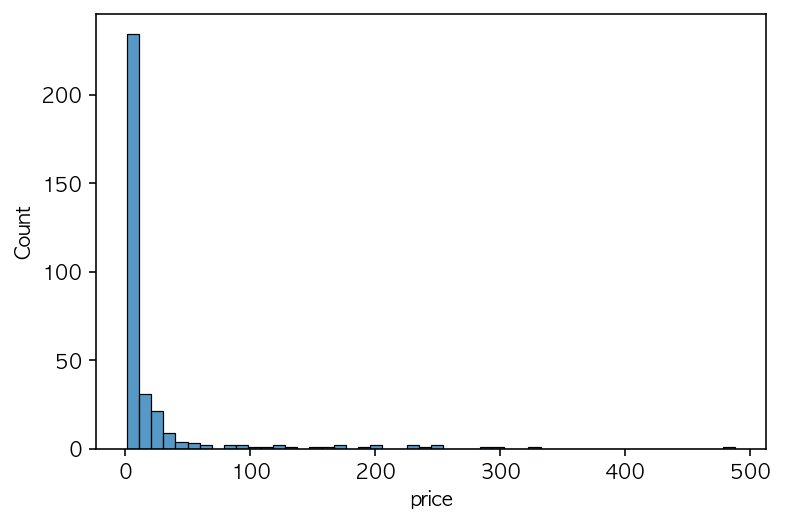

In [231]:
sns.histplot(normal_price['price'].value_counts(), bins=50)

In [232]:
# 5프로 잘라서 이상치 제거해본다.
lower = int(len(normal_price) * 0.025)
upper = int(len(normal_price) * 0.975)

In [233]:
test = normal_price.sort_values(by='price')[lower:upper]

### 2.1.2 시각화 함수 만들기
- **brand, product_type, color, used 별 날짜에 따른 가격변화**
- [ ] 브랜드별 시세추이 살펴보기
- [ ] 동일 브랜드 내에서 색상별 시세추이 살펴보기
- [ ] 동일 브랜드 내에서 제품 유형별 시세추이 살펴보기
- [ ] 동일 제품에서 used(중고/새상품) 시세추이 살펴보기
- [ ] release_price 가로선 긋기
- [ ] 시세추이 살펴볼 수 있는 모듈 만들기
- [ ] uid 동일판매자 살펴보기
- [ ] 사이즈별 가격 분포 살펴보기(시세추이?)
- [ ] status = 올린시점으로부터 가장 빨리 팔린 상품은 무엇인지 살펴보기 (판매완료, 예약완료)

In [234]:
df = test

### 2.2 브랜드별 시세추이 살펴보기

In [235]:
df['brand'].value_counts()

나이키     3210
조던      1890
뉴발란스    1711
Name: brand, dtype: int64

In [236]:
# 브랜드별 가격통계 살펴보기
pd.pivot_table(df, index='brand', values='price', aggfunc=['max', 'mean', 'median', 'min', 'std'])

,max,mean,median,min,std
,price,price,price,price,price
brand,,,,,
나이키,550000,282998,290000,120000,68195
뉴발란스,485000,299245,300000,120000,69733
조던,620000,299440,300000,120000,101169


In [237]:
# # 원하는 데이터 뽑기(제품유형/브랜드/색상/중고여부)
# df = test[test['brand'] == '나이키'].reset_index(drop=True)
# print(df.shape)
# df.head(1)

In [238]:
# # # 덩크로우 중고상품만 뽑아오기
# # dunklow = dunklow[(dunklow['used'] == 1) | (dunklow['used'] == 13)].reset_index(drop=True)
# # 덩크로우 새상품만 뽑아오기
# df = df[df['used'] == 2].reset_index(drop=True)
# print(df.shape)
# df.head(1)

In [239]:
# 원하는 분류 columns에 넣기 (brand/product_type/color/used)
# 해당날짜에 판매기록이 없으면 NaN으로 표시됨.
# aggfunc에서 median(중앙값-이상치에 덜 영향), mean(평균), count(몇개인지 보기위함)
# pivot_df = pd.pivot_table(df, index='date', columns='used', values='price', aggfunc=['median','mean','count']).sort_index()
pivot_df = pd.pivot_table(df, index='date', columns='brand', values='price', aggfunc=['median','mean','count']).sort_index()
print(pivot_df.shape)
pivot_df.head()

(279, 9)


median               mean               count         
brand         나이키   뉴발란스     조던  나이키   뉴발란스     조던   나이키 뉴발란스  조던
date                                                             
2020-11-13    NaN    NaN 400000  NaN    NaN 400000   NaN  NaN   2
2020-11-16    NaN    NaN 449000  NaN    NaN 449000   NaN  NaN   1
2020-11-26    NaN 150000    NaN  NaN 150000    NaN   NaN    1 NaN
2020-11-28    NaN    NaN 379000  NaN    NaN 379000   NaN  NaN   1
2020-12-11    NaN 250000    NaN  NaN 246667    NaN   NaN    3 NaN

In [240]:
# # 날짜 범위 만들기
# # 2020-11-11 부터 2021-11-11까지, 13번
# import datetime

# start_date = pd.to_datetime('2020-11-11')
# end_date = pd.to_datetime('2021-11-11')
# date_range_list = pd.date_range(start_date, end_date, periods=13)
# date_range_list = [x.strftime("%Y-%m-%d") for x in date_range_list]

In [241]:
# date_range_list = ['2020-11-11', '2020-12-11', '2021-01-11', '2021-02-11', '2021-03-11', '2021-04-11',
#                   '2021-05-11', '2021-06-11', '2021-07-11', '2021-08-11', '2021-09-11', '2021-10-11', '2021-11-11']
# # date_range_list = ['2021-03-11', '2021-04-11', '2021-05-11', '2021-06-11', '2021-07-11', '2021-08-11', '2021-09-11', '2021-10-11', '2021-11-11']

In [242]:
column_list = pivot_df['mean'].columns

In [243]:
column_list

Index(['나이키', '뉴발란스', '조던'], dtype='object', name='brand')

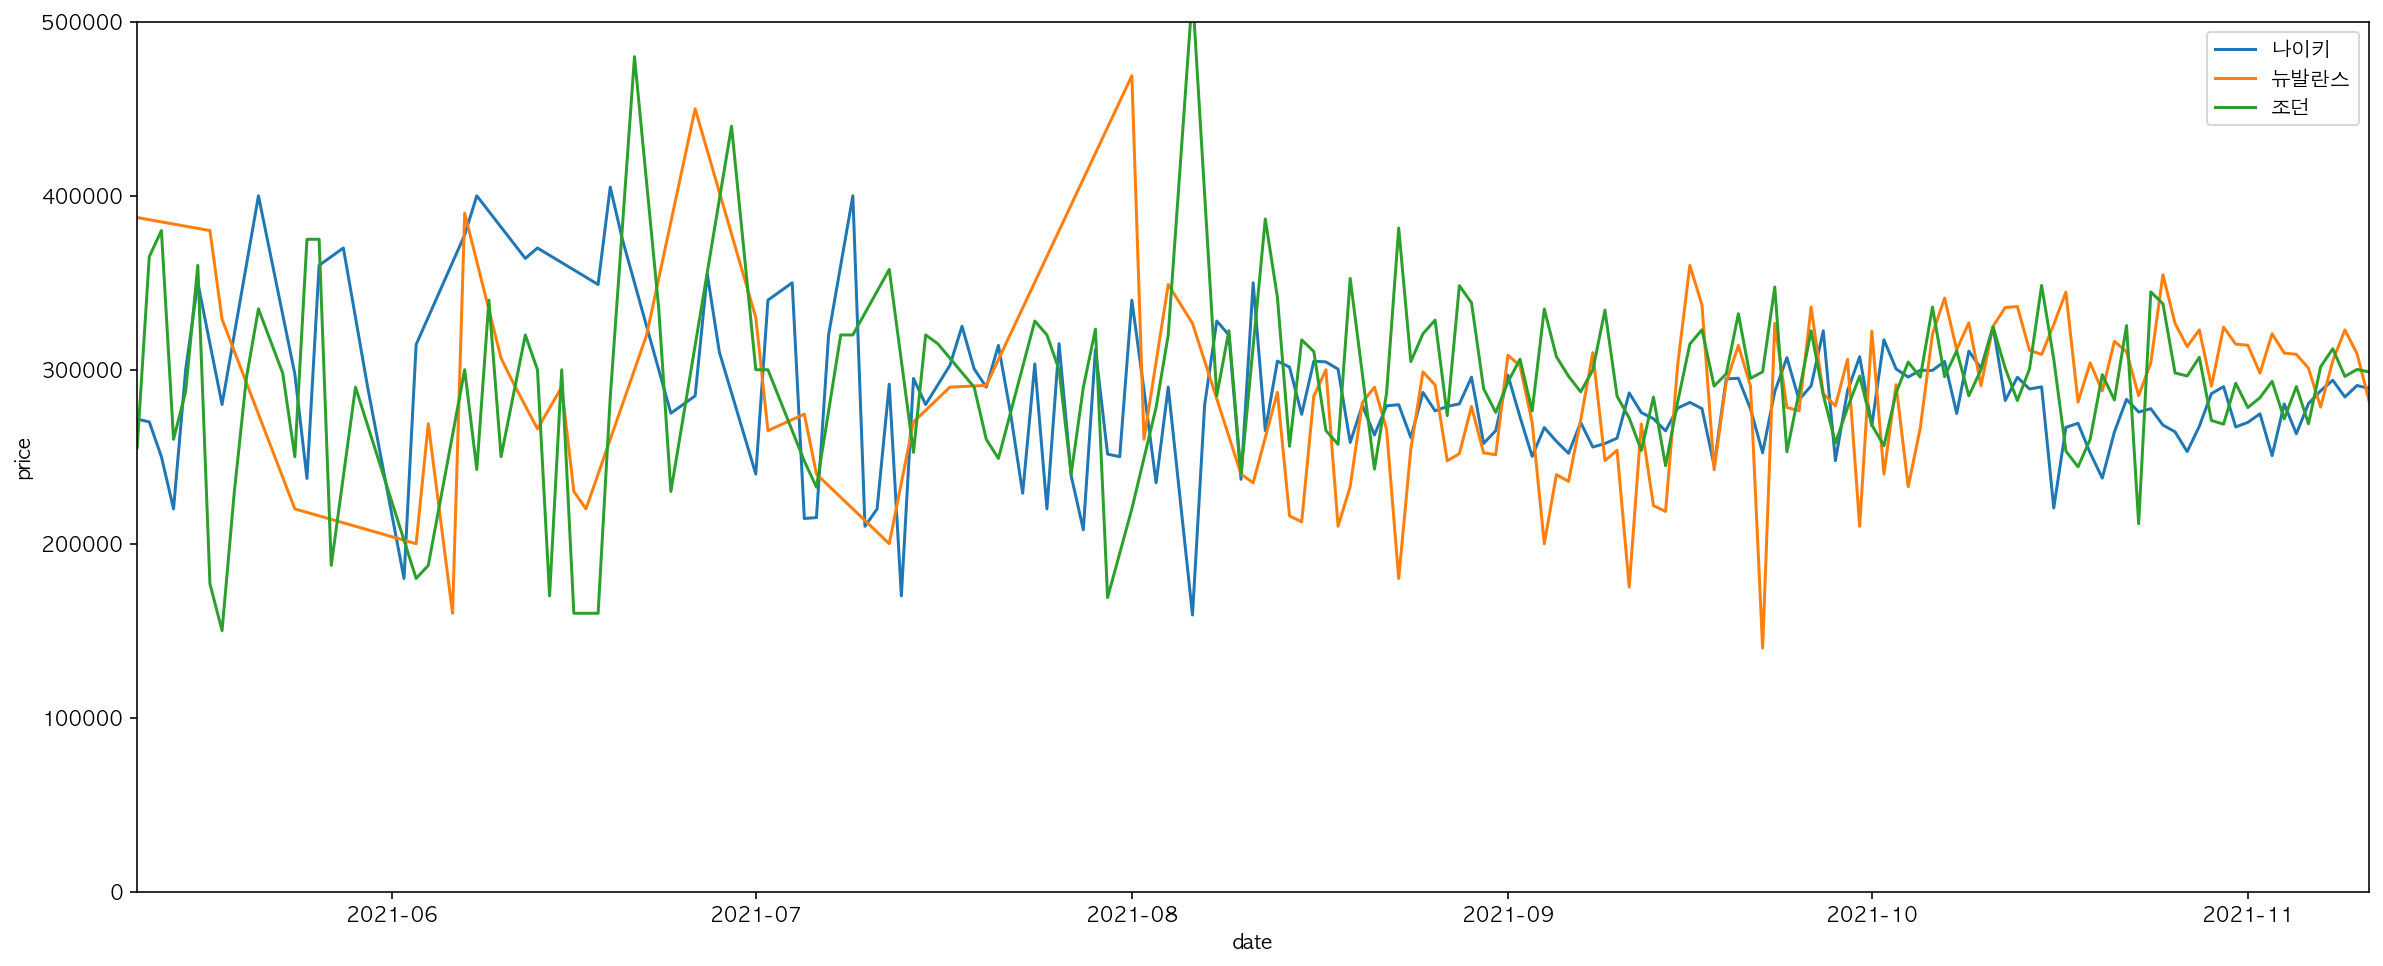

In [244]:
# median을 사용하는 이유는 이상치의 영향을 덜 받기 때문.
# 이상치를 제거했기에 mean을 사용해도 됨. (더 자연스러운 그래프를 위해)
# 시각화 함수 선언
# def make_lineplot(column_list):
plt.figure(figsize=(20,8))
for col in column_list:
    sns.lineplot(data=pivot_df['mean'], x=pivot_df['mean'].index, y=pivot_df['mean'][col], label=col)
# plt.title('')
plt.xlabel('date')
plt.ylabel('price')
# plt.xticks(date_range_list, rotation=0)
plt.ylim([0,500000])
plt.xlim(pd.to_datetime(['2021-05-11', '2021-11-11']))
plt.legend()
plt.show()

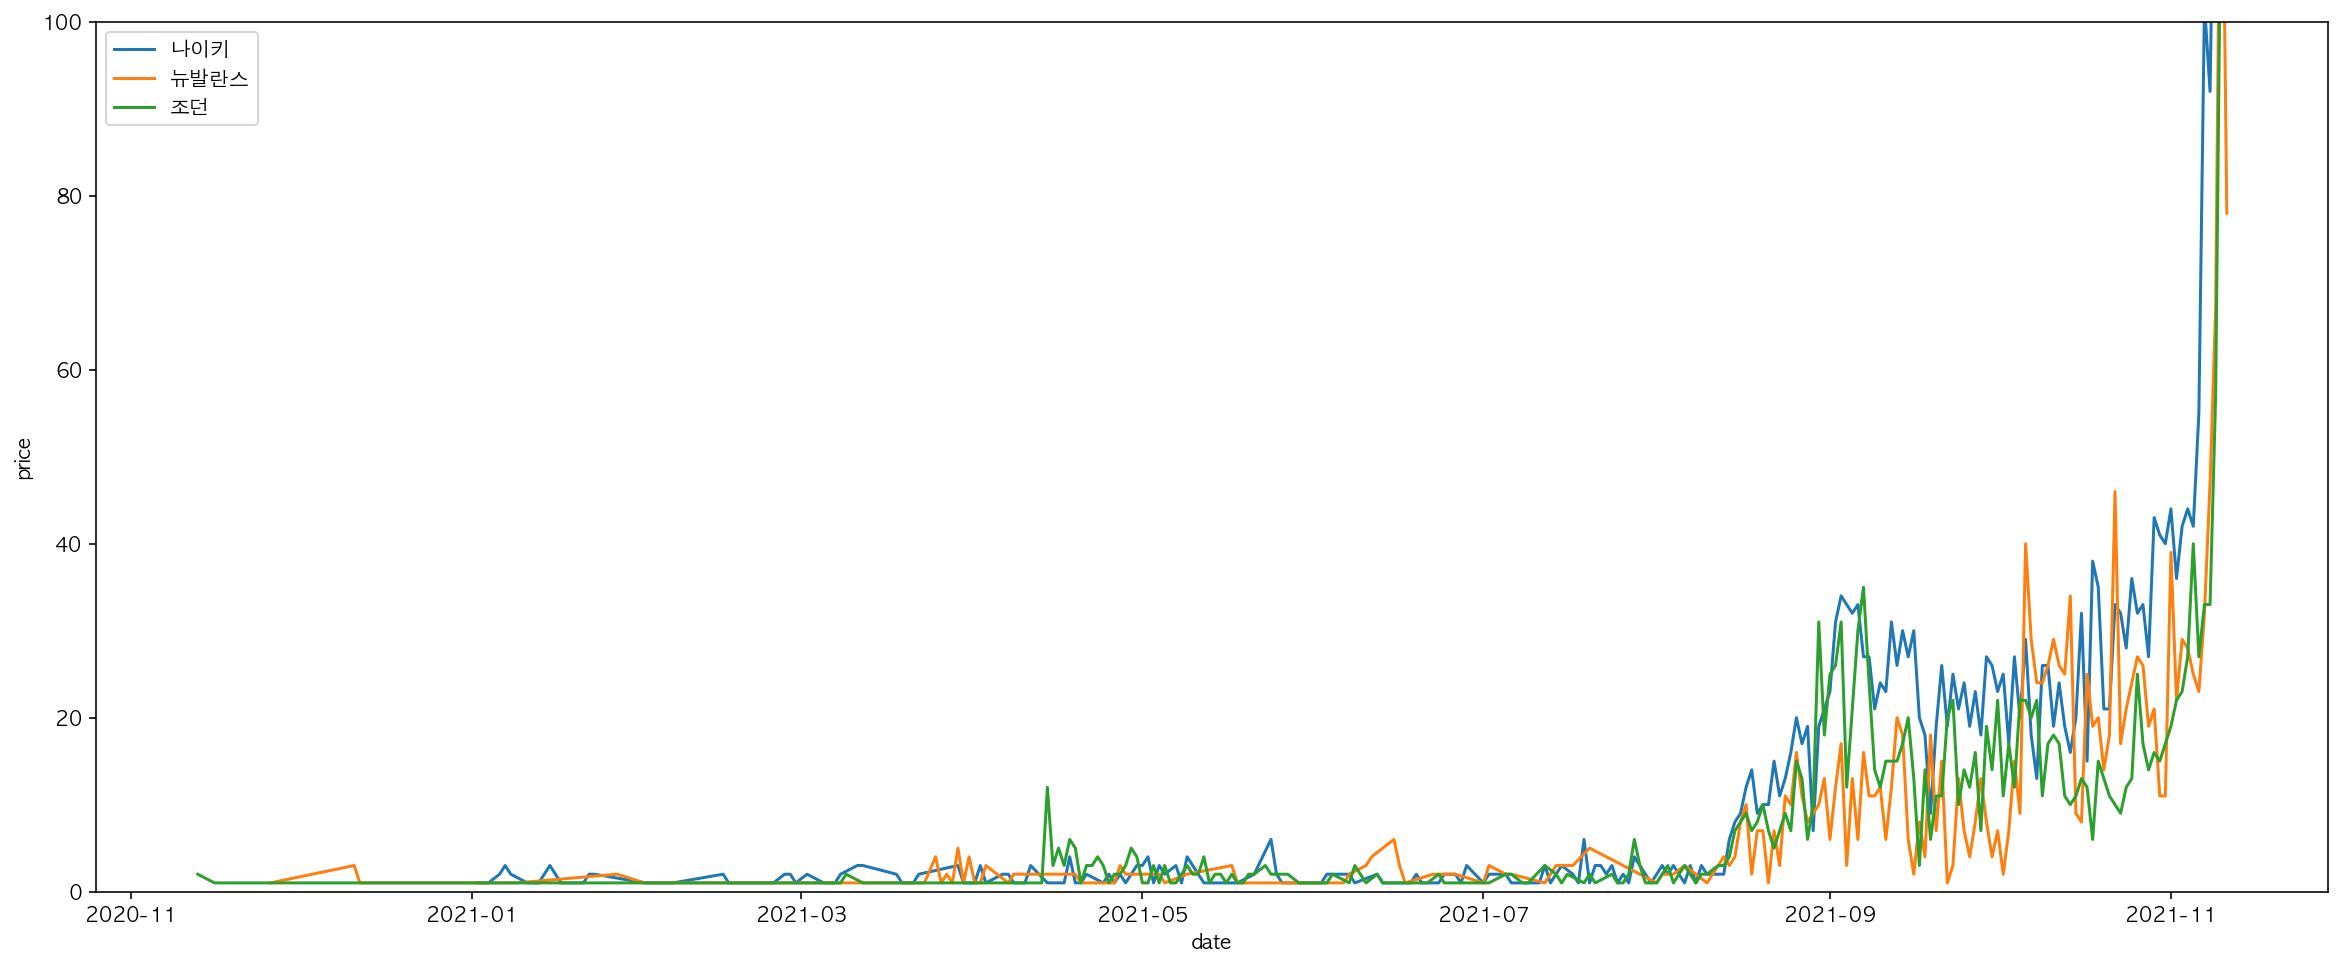

In [246]:
# 거래량의 변화
# median을 사용하는 이유는 이상치의 영향을 덜 받기 때문.
# 이상치를 제거했기에 mean을 사용해도 됨. (더 자연스러운 그래프를 위해)
# 시각화 함수 선언
# def make_lineplot(column_list):
plt.figure(figsize=(20,8))
for col in column_list:
    sns.lineplot(data=pivot_df['count'], x=pivot_df['count'].index, y=pivot_df['count'][col], label=col)
    # sns.lineplot(data=pivot_df, x=pivot_df.index, y=pivot_df['median', '유니버시티블루'], label='유니버시티블루')
# plt.title('')
plt.xlabel('date')
plt.ylabel('price')
# plt.xticks(date_range_list, rotation=0)
plt.ylim([0,100])
# plt.xlim(pd.to_datetime(['2021-05-11', '2021-11-11']))
plt.legend()
plt.show()

### 2.3 동일 브랜드 내 색상별 시세 변화

In [247]:
df[df['brand']=='나이키']['color'].value_counts()

범고래        2093
라이트본        191
유니버시티블루     180
네이비         174
골든로드        172
코스트         150
바시티그린       150
오렌지         100
Name: color, dtype: int64

In [248]:
# 가격통계 살펴보기
pd.pivot_table(df[df['brand']=='나이키'], index='color', values='price', aggfunc=['max', 'mean', 'median', 'min', 'std'])

,max,mean,median,min,std
,price,price,price,price,price
color,,,,,
골든로드,280000,161494,159000,130000,22153
네이비,399000,202103,199500,129000,36483
라이트본,350000,265932,265000,160000,31001
바시티그린,529000,311813,305000,180000,62717
범고래,550000,304066,300000,120000,54523
오렌지,300000,182400,180000,120000,40735
유니버시티블루,495000,254978,250000,120000,58323
코스트,519000,315780,320000,140000,70801


In [249]:
# 나이키 브랜드의 색상별 시세 변화
# aggfunc에서 median(중앙값-이상치에 덜 영향), mean(평균), count(몇개인지 보기위함)
pivot_df = pd.pivot_table(df[df['brand']=='나이키'], index='date', columns='color', values='price', aggfunc=['median','mean','count']).sort_index()
print(pivot_df.shape)
pivot_df.head()

(225, 24)


median                                          mean           \
color        골든로드 네이비 라이트본 바시티그린    범고래 오렌지 유니버시티블루    코스트 골든로드 네이비 라이트본   
date                                                                       
2021-01-02    NaN NaN  NaN   NaN 500000 NaN     NaN    NaN  NaN NaN  NaN   
2021-01-04    NaN NaN  NaN   NaN 230000 NaN     NaN    NaN  NaN NaN  NaN   
2021-01-06    NaN NaN  NaN   NaN 400000 NaN     NaN 400000  NaN NaN  NaN   
2021-01-07    NaN NaN  NaN   NaN 418000 NaN     NaN 390000  NaN NaN  NaN   
2021-01-08    NaN NaN  NaN   NaN 330000 NaN     NaN 420000  NaN NaN  NaN   

                                           count                         \
color      바시티그린    범고래 오렌지 유니버시티블루    코스트  골든로드 네이비 라이트본 바시티그린 범고래 오렌지   
date                                                                      
2021-01-02   NaN 500000 NaN     NaN    NaN   NaN NaN  NaN   NaN   1 NaN   
2021-01-04   NaN 230000 NaN     NaN    NaN   NaN NaN  NaN   NaN   1 NaN   
2021-01-06   NaN 400000 NaN     NaN 400000   NaN NaN  NaN   NaN   1 NaN   
2021-01-07   NaN 418000 NaN     NaN 390000   NaN NaN  NaN   NaN   1 NaN   
2021-01-08   NaN 330000 NaN     NaN 420000   NaN NaN  NaN   NaN   1 NaN   

                        
color      유니버시티블루 코스트  
date                    
2021-01-02     NaN NaN  
2021-01-04     NaN NaN  
2021-01-06     NaN   1  
2021-01-07     NaN   2  
2021-01-08     NaN   1

In [250]:
column_list = pivot_df['mean'].columns
column_list

Index(['골든로드', '네이비', '라이트본', '바시티그린', '범고래', '오렌지', '유니버시티블루', '코스트'], dtype='object', name='color')

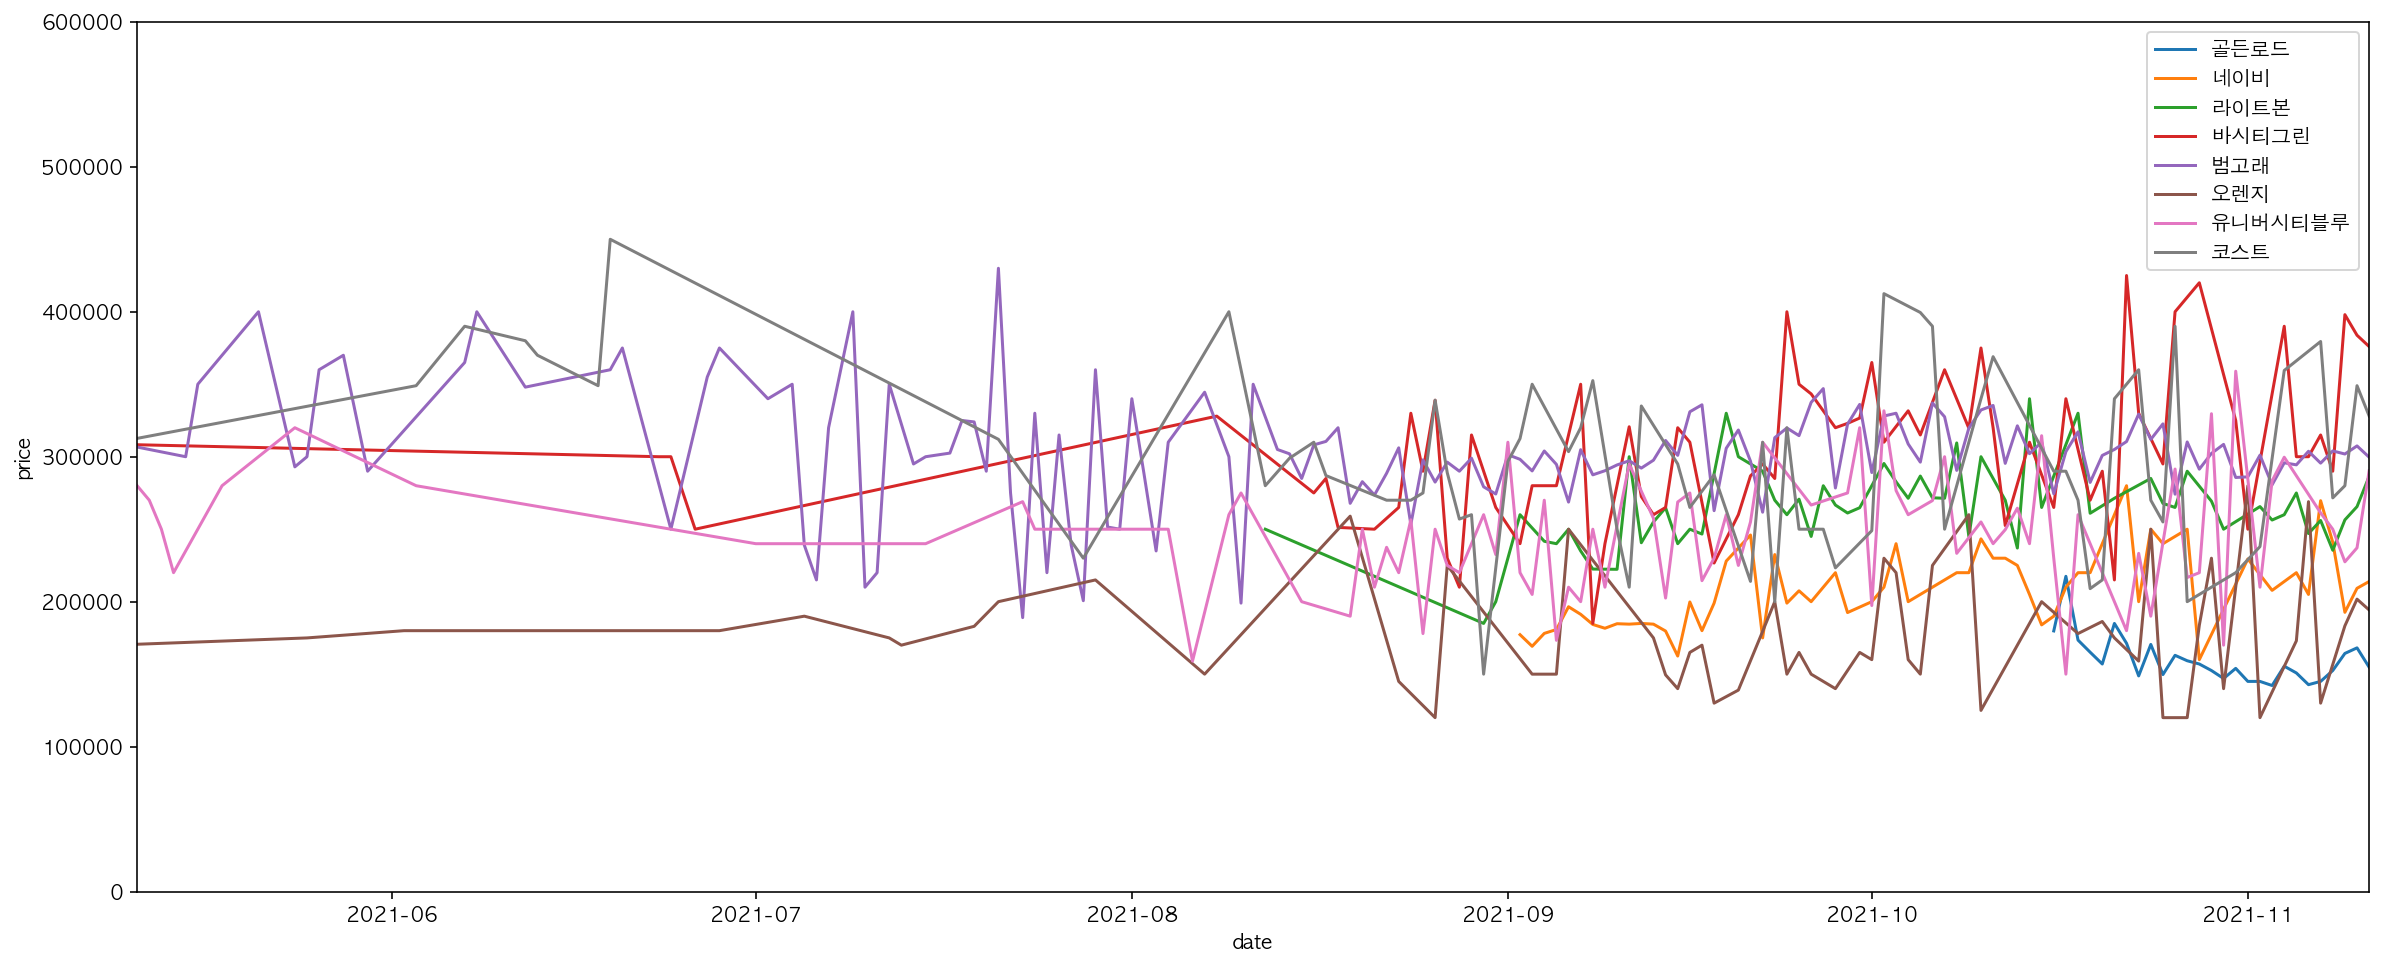

In [255]:
plt.figure(figsize=(20,8))
for col in column_list:
    sns.lineplot(data=pivot_df['mean'], x=pivot_df['mean'].index, y=pivot_df['mean'][col], label=col, markers=True, markersize=14)
# plt.title('')
plt.xlabel('date')
plt.ylabel('price')
# plt.xticks(date_range_list, rotation=0)
plt.ylim([0,600000])
plt.xlim(pd.to_datetime(['2021-05-11', '2021-11-11']))
plt.legend()
plt.show()

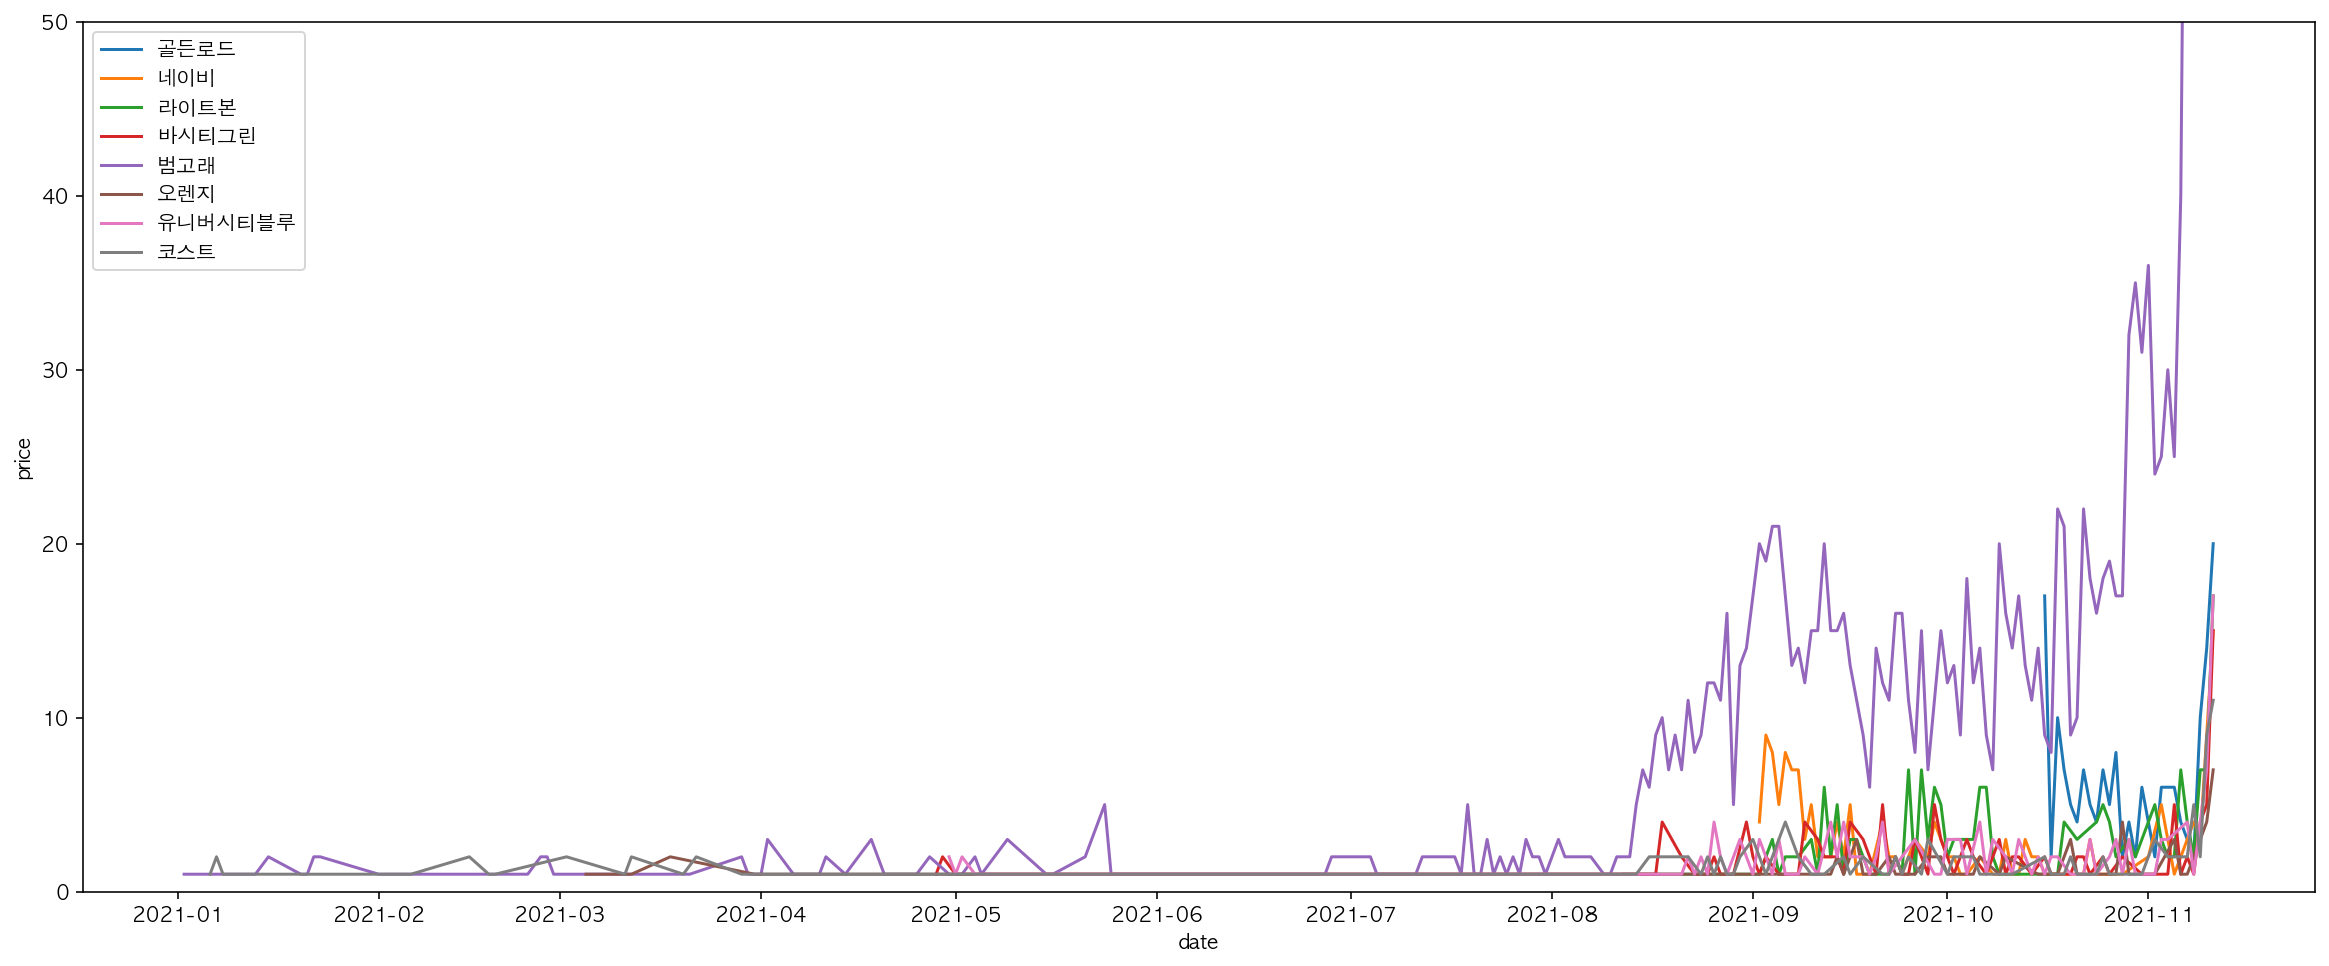

In [258]:
plt.figure(figsize=(20,8))
for col in column_list:
    sns.lineplot(data=pivot_df['count'], x=pivot_df['count'].index, y=pivot_df['count'][col], label=col)
    # sns.lineplot(data=pivot_df, x=pivot_df.index, y=pivot_df['median', '유니버시티블루'], label='유니버시티블루')
# plt.title('')
plt.xlabel('date')
plt.ylabel('price')
# plt.xticks(date_range_list, rotation=0)
plt.ylim([0,50])
# plt.xlim(pd.to_datetime(['2021-05-11', '2021-11-11']))
plt.legend()
plt.show()

### 2.3 동일 브랜드 내에서 제품 유형별 시세추이 살펴보기

In [293]:
df[df['brand']=='조던']['product_type'].value_counts()

조던1 하이     892
조던1 미드     611
조던 1 로우    387
Name: product_type, dtype: int64

In [294]:
# 가격통계 살펴보기
pd.pivot_table(df[df['brand']=='조던'], index='product_type', values='price', aggfunc=['max', 'mean', 'median', 'min', 'std'])

,max,mean,median,min,std
,price,price,price,price,price
product_type,,,,,
조던 1 로우,450000,302780,300000,170000,38019
조던1 미드,600000,260072,260000,120000,98040
조던1 하이,620000,324957,320000,120000,113019


In [295]:
# 조던 브랜드의 제품타입별 시세 변화
# aggfunc에서 median(중앙값-이상치에 덜 영향), mean(평균), count(몇개인지 보기위함)
pivot_df = pd.pivot_table(df[df['brand']=='조던'], index='date', columns='product_type', values='price', aggfunc=['median','mean','count']).sort_index()
print(pivot_df.shape)
pivot_df.head()

(205, 9)


median                  mean                 count              
product_type 조던 1 로우 조던1 미드 조던1 하이 조던 1 로우 조던1 미드 조던1 하이 조던 1 로우 조던1 미드 조던1 하이
date                                                                          
2020-11-13       NaN    NaN 400000     NaN    NaN 400000     NaN    NaN      2
2020-11-16       NaN    NaN 449000     NaN    NaN 449000     NaN    NaN      1
2020-11-28       NaN    NaN 379000     NaN    NaN 379000     NaN    NaN      1
2020-12-14       NaN    NaN 599000     NaN    NaN 599000     NaN    NaN      1
2020-12-26       NaN    NaN 510000     NaN    NaN 510000     NaN    NaN      1

In [296]:
column_list = pivot_df['mean'].columns
column_list

Index(['조던 1 로우', '조던1 미드', '조던1 하이'], dtype='object', name='product_type')

In [297]:
list(column_list)

['조던 1 로우', '조던1 미드', '조던1 하이']

In [299]:
color_list = ['r', 'b', 'g']

In [313]:
for i, j in zip(column_list, color_list):
    print(i)
    print(j)

조던 1 로우
r
조던1 미드
b
조던1 하이
g


In [209]:
print(zip(list(column_list), ['r', 'b', 'g']))

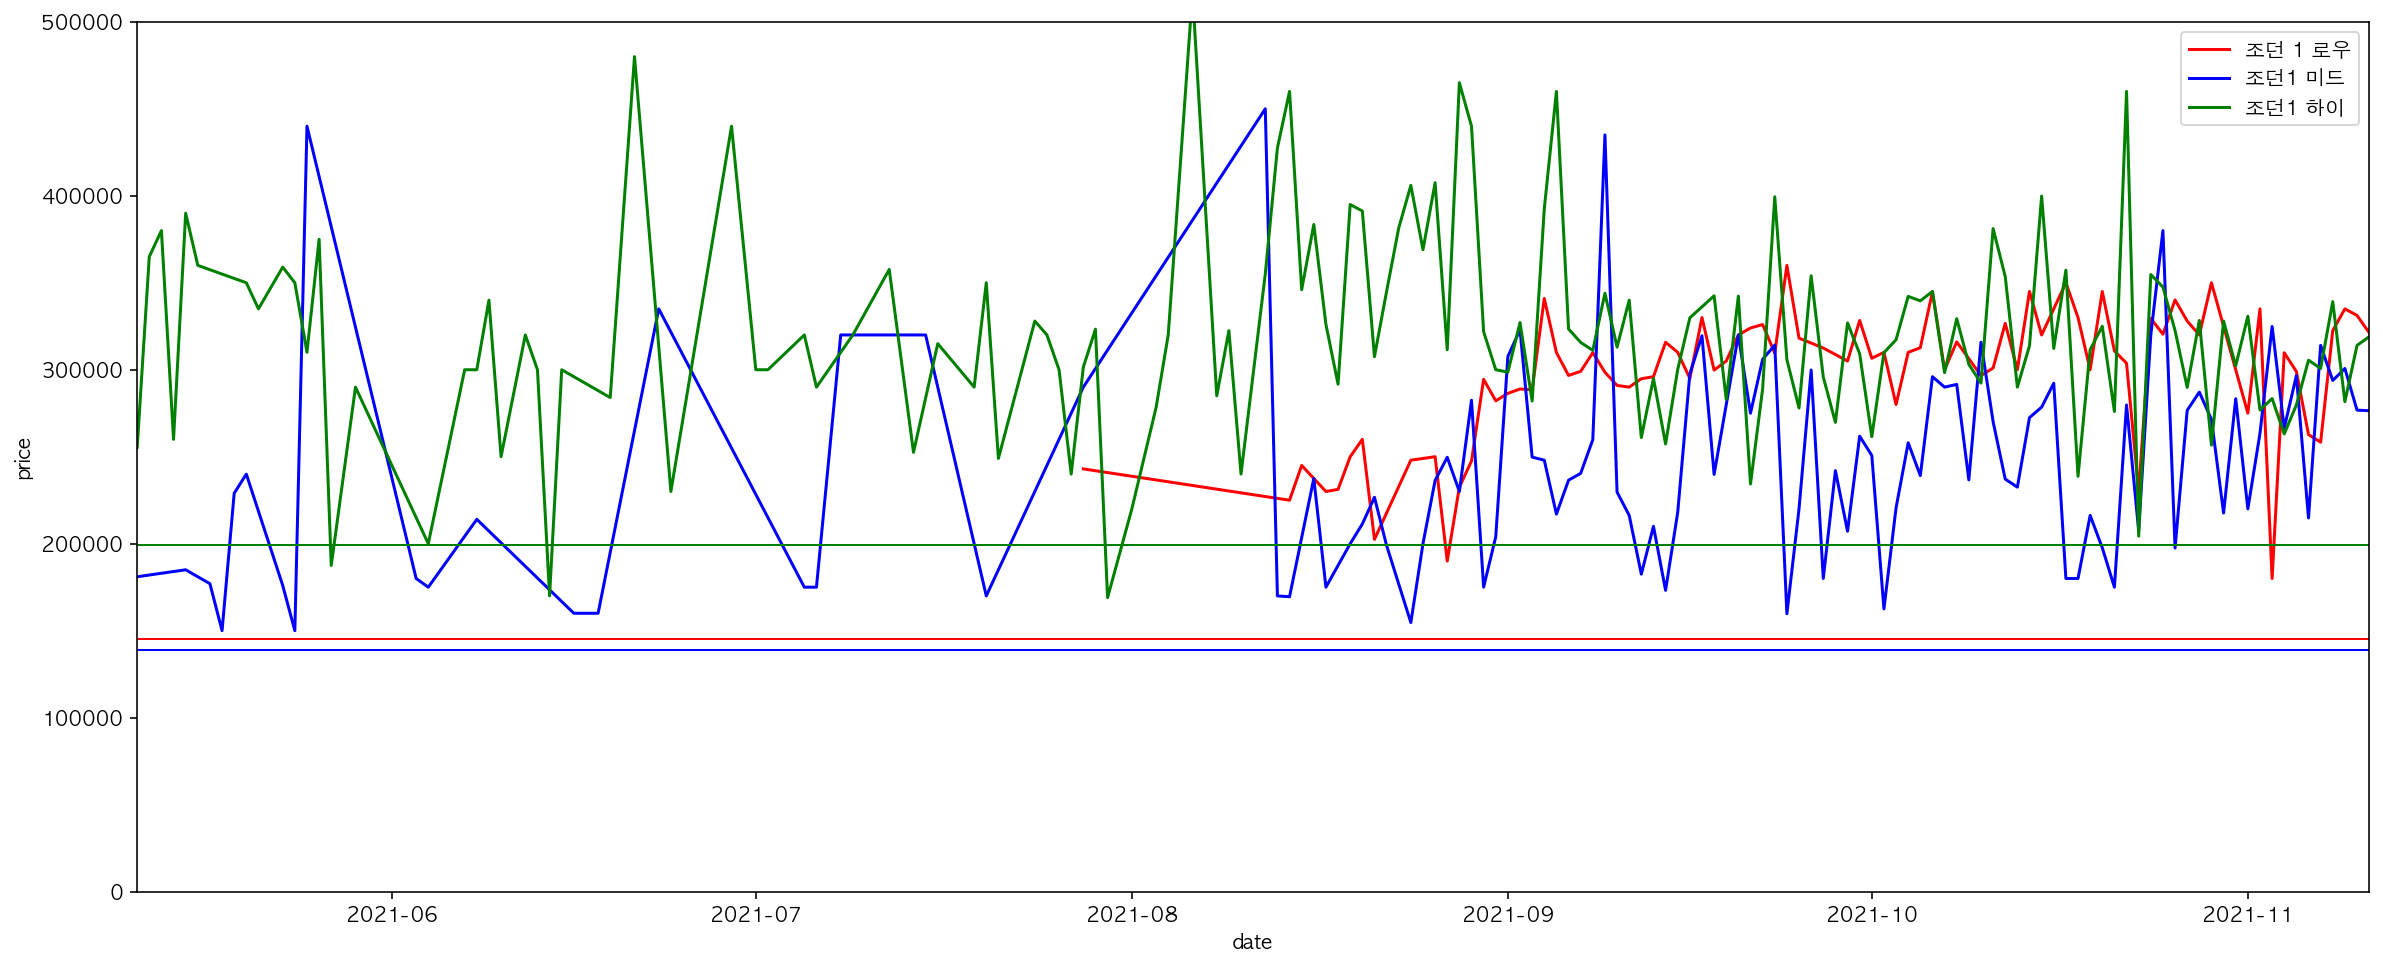

In [318]:
plt.figure(figsize=(20,8))
for col, cr in zip(column_list, color_list):
    sns.lineplot(data=pivot_df['mean'], x=pivot_df['mean'].index, y=pivot_df['mean'][col], label=col, color=cr)
    plt.axhline(y=df[df['product_type']==col]['release_price'].mean(), color=cr , linewidth=1)
# plt.title('')
plt.xlabel('date')
plt.ylabel('price')
# plt.xticks(date_range_list, rotation=0)
plt.ylim([0,500000])
plt.xlim(pd.to_datetime(['2021-05-11', '2021-11-11']))
plt.legend()
plt.show()

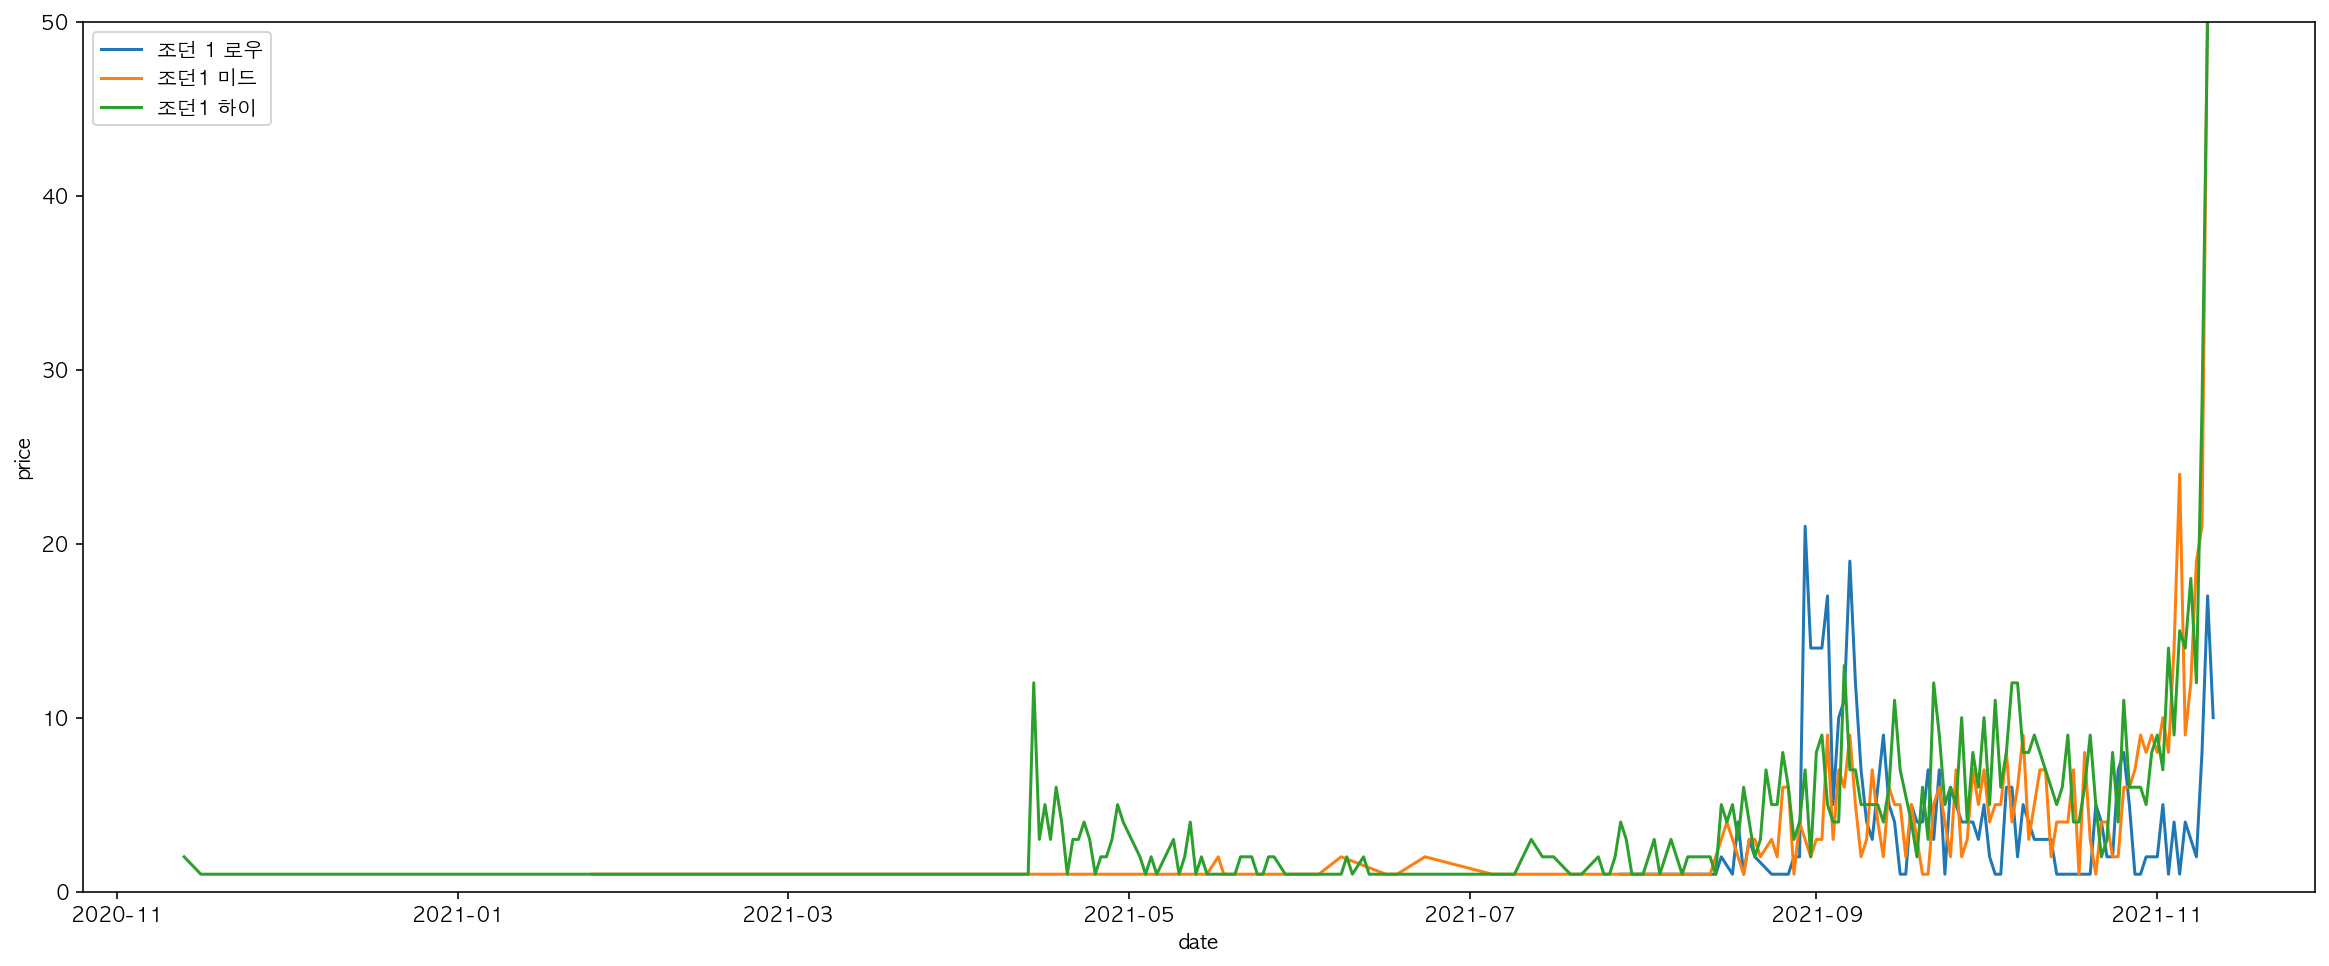

In [198]:
plt.figure(figsize=(20,8))
for col in column_list:
    sns.lineplot(data=pivot_df['count'], x=pivot_df['count'].index, y=pivot_df['count'][col], label=col)
    # sns.lineplot(data=pivot_df, x=pivot_df.index, y=pivot_df['median', '유니버시티블루'], label='유니버시티블루')
# plt.title('')
plt.xlabel('date')
plt.ylabel('price')
# plt.xticks(date_range_list, rotation=0)
plt.ylim([0,50])
# plt.xlim(pd.to_datetime(['2021-05-11', '2021-11-11']))
plt.legend()
plt.show()

### 2.4 지도 시각화

In [259]:
# !pip install folium
import folium

# 코로플레스를 위한 시/군/구별 좌표 json파일 가져오기
import json

geo_path = './data/skorea_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

In [260]:
rawdata_count = pd.pivot_table(rawdata, index='location2', values='pid', aggfunc='count')

In [268]:
rawdata_count = rawdata_count.drop('NUL')

In [270]:
# 코로플레스 지도 그리기
m = folium.Map(location=[35, 127], zoom_start=7, tiles='OpenStreetMap')  #tiles = 'Stamen Toner', 'OpenStreetMap', 'Stamen Terrain'

m.choropleth(
    geo_data = geo_str,
    data = rawdata_count['pid'],
    columns = ['location1','pid'],
               fill_color = 'PuRd', # 'BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuBuGn', 'PuRd', 'RdPu', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd'
               key_on = 'feature.properties.name',
               legend_name='Number of bunkae_transaction (%)')

m.save('bunkae_location.html')
m

In [276]:
# 어디에서 많이 팔았나
rawdata_count.sort_values(by='pid', ascending=False).head(20)

,pid
location2,
서구,223
남구,197
수원시,188
부천시,177
송파구,169
북구,159
성남시,156
고양시,150
중구,149


In [280]:
# 누가 가장 상품을 많이 올렸나
pd.pivot_table(rawdata, index='uid', values='pid', aggfunc='count').sort_values(by='pid', ascending=False).head(10)

,pid
uid,
7623840,58
9870858,21
7930580,18
4926683,17
3664903,16
76961884,16
4322440,16
10405026,14
5032948,12


In [281]:
# 7623840 유저가 제일 많이 상품 올림
rawdata[rawdata['uid'] == 7623840]['product_name'].value_counts()

나이키 덩크로우 코스트        13
나이키 덩크로우 범고래        13
조던1 미드 짐레드           6
뉴발란스 992 화이트실버       5
나이키 덩크하이 범고래         4
뉴발란스 992 네이비         4
조던1 하이 다크모카          3
조던1 미드 그레이포그         2
뉴발란스 992 그레이         2
나이키 덩크로우 유니버시티블루     2
조던1 미드 울프그레이         2
조던1 하이 하이퍼로얄         1
나이키 덩크하이 오렌지         1
Name: product_name, dtype: int64

In [283]:
# 7623840 유저는 상품은 많이 올렸는데 판매완료가 훨씬 적다
rawdata[rawdata['uid'] == 7623840]['status'].value_counts()

판매중     44
판매완료    14
Name: status, dtype: int64

In [291]:
# 7623840 유저는 군포 큰손, 예전 상품도 안팔린게 많음. 시세 반영을 다시 안하는듯.
rawdata[(rawdata['uid'] == 7623840) & (rawdata['status'] == '판매중')].sort_values(by='date')

,pid,uid,product_name,brand,product_type,color,size,price,release_price,datetime,date,location1,location2,status,used,name,abnormal_price
1154,138092205,7623840,조던1 하이 다크모카,조던,조던1 하이,다크모카,250,599000,199000,2020-12-14 11:06:19,2020-12-14,경기도,군포시,판매중,새상품,[250] 나이키 에어조던1 하이 다크모카,False
673,142820695,7623840,나이키 덩크로우 코스트,나이키,나이키 덩크로우,코스트,235,390000,119000,2021-02-02 10:07:03,2021-02-02,경기도,군포시,판매중,새상품,[235] 나이키 덩크 로우 코스트 unc블루,False
672,142784095,7623840,나이키 덩크로우 코스트,나이키,나이키 덩크로우,코스트,270,450000,119000,2021-02-06 09:45:13,2021-02-06,경기도,군포시,판매중,새상품,[270] 나이키 덩크 로우 코스트,False
5288,144610146,7623840,조던1 하이 하이퍼로얄,조던,조던1 하이,하이퍼로얄,260,149000,199000,2021-02-08 10:11:30,2021-02-08,경기도,군포시,판매중,새상품,[260] 나이키 에어조던1 미드 하이퍼로얄,False
669,142566691,7623840,나이키 덩크로우 코스트,나이키,나이키 덩크로우,코스트,230,399000,119000,2021-02-18 11:13:49,2021-02-18,경기도,군포시,판매중,새상품,[230] 나이키 덩크 로우 코스트 unc블루,False
668,143296294,7623840,나이키 덩크로우 코스트,나이키,나이키 덩크로우,코스트,245,390000,119000,2021-02-19 10:37:44,2021-02-19,경기도,군포시,판매중,새상품,[245] 나이키 덩크로우 코스트 unc블루,False
2274,148486126,7623840,나이키 덩크로우 범고래,나이키,나이키 덩크로우,범고래,255,390000,119000,2021-03-11 12:37:20,2021-03-11,경기도,군포시,판매중,새상품,[255] 나이키 덩크 로우 검흰 범고래,False
662,148299254,7623840,나이키 덩크로우 코스트,나이키,나이키 덩크로우,코스트,230,380000,119000,2021-03-22 10:08:40,2021-03-22,경기도,군포시,판매중,새상품,[230] 나이키 덩크 로우 unc 블루 코스트,False
660,150136568,7623840,나이키 덩크로우 코스트,나이키,나이키 덩크로우,코스트,235,390000,119000,2021-03-29 11:46:48,2021-03-29,경기도,군포시,판매중,새상품,[235] 나이키 덩크로우 코스트,False
2270,150158448,7623840,나이키 덩크로우 범고래,나이키,나이키 덩크로우,범고래,250,399000,119000,2021-03-29 16:01:27,2021-03-29,경기도,군포시,판매중,새상품,[250] 나이키 덩크 로우 검흰 범고래,False
